In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from scipy import stats
import statistics
from sklearn.model_selection import train_test_split

import time
# for preprocessing the data
from sklearn.preprocessing import StandardScaler


# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from mord import LogisticAT
import xgboost as xgb
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier

# for combining the preprocess with model training
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import  LabelEncoder

# for optimizing the hyperparameters of the pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.model_selection import RandomizedSearchCV

# For accuracy Score
from sklearn.metrics import accuracy_score


from impyute.imputation.cs import fast_knn
import sys

In [64]:
def get_datasets():
    train = pd.read_csv("Train.csv")
    test = pd.read_csv("Test.csv")
    return train, test
train, test = get_datasets()

In [4]:
train.shape

(8068, 11)

In [5]:
train.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


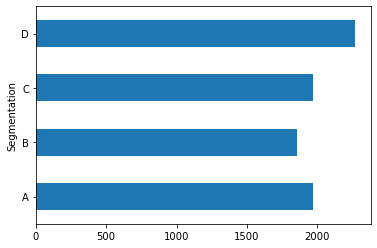

In [6]:
#colormap = ['red', 'blue', 'yellow', 'green']
train.groupby("Segmentation")['ID'].count().plot(kind='barh')

In [7]:
def perc_stacked_graph(dataset, X, Y, Z, axs, figsize=(5,5)):
    # in a pivot table -> X - row, y - Column, Z - Values
    perc_stacked = dataset.pivot_table(index=[X], columns=Y, values=Z, aggfunc='count').reset_index()
    #perc_stacked.drop(['land_surface_condition'], axis=1)

    perc_stacked = perc_stacked.set_index(perc_stacked[X], drop=True)
    perc_stacked = perc_stacked.drop([X], axis=1)
    for row in perc_stacked.index:
        perc_stacked.loc[row] = perc_stacked.loc[row]/np.sum(perc_stacked.loc[row], axis=0)
    perc_stacked.plot(ax=axs, kind = 'bar', figsize=(15,15))

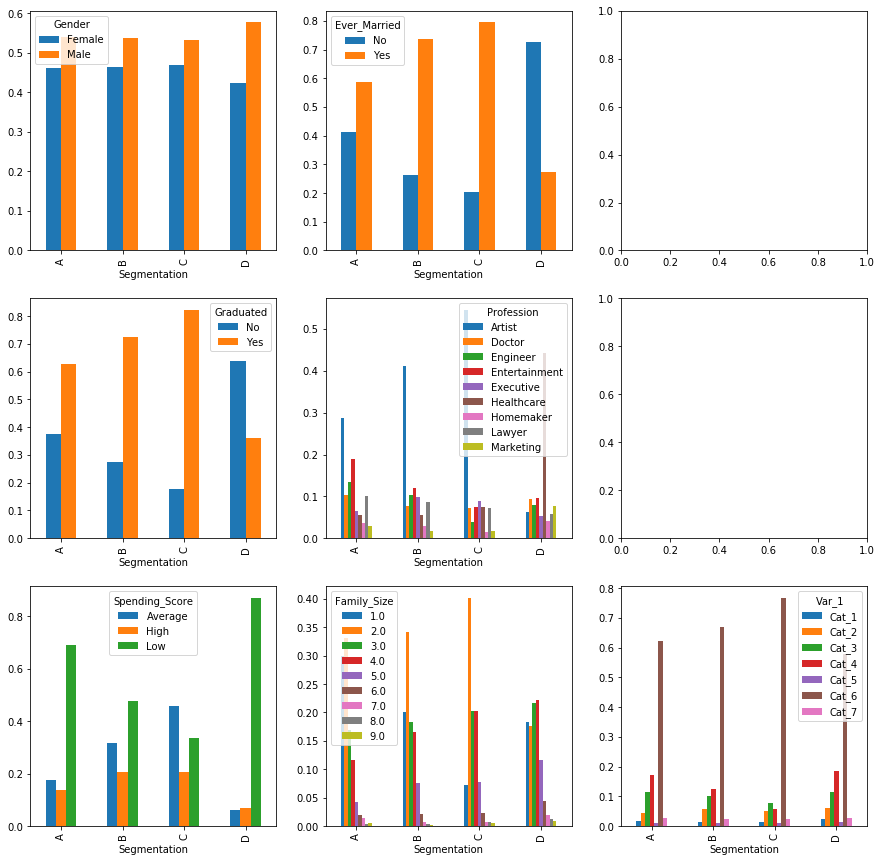

In [8]:
fig, axs = plt.subplots(3,3)

perc_stacked_graph(train, "Segmentation", "Gender", "ID", axs = axs[0,0])
perc_stacked_graph(train, "Segmentation", "Ever_Married", "ID", axs = axs[0,1])
#perc_stacked_graph(train, "Segmentation", "Age", "ID", axs = axs[0,2])
perc_stacked_graph(train, "Segmentation", "Graduated", "ID", axs = axs[1,0])
perc_stacked_graph(train, "Segmentation", "Profession", "ID", axs = axs[1,1])
#perc_stacked_graph(train, "Segmentation", "Work_Experience", "ID", axs = axs[1,2])
perc_stacked_graph(train, "Segmentation", "Spending_Score", "ID", axs = axs[2,0])
perc_stacked_graph(train, "Segmentation", "Family_Size", "ID", axs = axs[2,1])
perc_stacked_graph(train, "Segmentation", "Var_1", "ID", axs = axs[2,2])

plt.show()

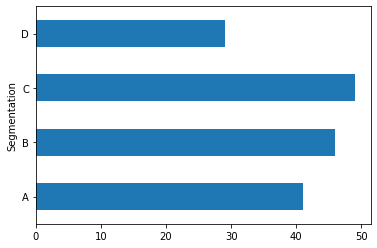

In [9]:
train.groupby("Segmentation")["Age"].median().plot(kind='barh')

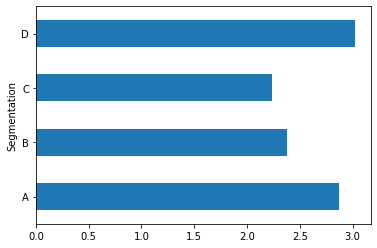

In [10]:
train.groupby("Segmentation")['Work_Experience'].mean().plot(kind='barh')

In [79]:
def chi_square_test(train):
    categ_col_list = train.select_dtypes(exclude='number').columns
    chi_df = pd.DataFrame(columns=categ_col_list, index=categ_col_list)
    for i in categ_col_list:
        for j in categ_col_list:
            cross = pd.crosstab(train[i], train[j])

            chi_stat = stats.chi2_contingency(cross)
            p_chi_stat = chi_stat[1]
            chi_df.loc[i,j] = p_chi_stat
    return chi_df
chi_sq = chi_square_test(train)
chi_sq[chi_sq > 0.05]

,Gender,Ever_Married,Graduated,Profession,Spending_Score,Var_1,Segmentation
Gender,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ever_Married,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Graduated,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Profession,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Spending_Score,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Var_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Segmentation,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,Age,Work_Experience,Family_Size
Age,1.000000,-0.190789,-0.280517
Work_Experience,-0.190789,1.000000,-0.063234
Family_Size,-0.280517,-0.063234,1.000000


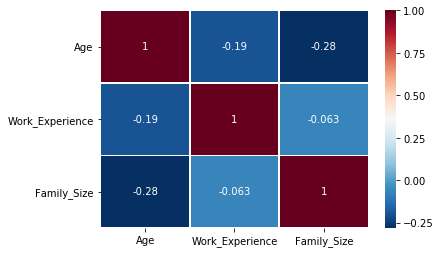

In [83]:
def pearson_cor(dataset):
    pearsoncorr = dataset._get_numeric_data().corr()
    sns.heatmap(pearsoncorr, 
                xticklabels=pearsoncorr.columns,
                yticklabels=pearsoncorr.columns,
                cmap='RdBu_r',
                annot=True,
                linewidth=0.5)
    #pearsoncorr.to_csv("correlation matrix.csv")
    return pearsoncorr
pearson_cor(train.drop("ID", axis=1))

In [86]:
train.describe()

,ID,Age,Work_Experience,Family_Size
count,8068.000000,8068.000000,7239.000000,7733.000000
mean,463479.214551,43.466906,2.641663,2.850123
std,2595.381232,16.711696,3.406763,1.531413
min,458982.000000,18.000000,0.000000,1.000000
25%,461240.750000,30.000000,0.000000,2.000000
50%,463472.500000,40.000000,1.000000,3.000000
75%,465744.250000,53.000000,4.000000,4.000000
max,467974.000000,89.000000,14.000000,9.000000


In [98]:
train.isnull().sum()

ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
Segmentation         0
dtype: int64

In [124]:
def clean_data(dataset):
    dataset['Ever_Married'] = dataset['Ever_Married'].map({'Yes':1, 'No':0})
    dataset['Graduated'] = dataset['Graduated'].map({'Yes':1, 'No':0})
    
    #dataset.loc[dataset['Ever_Married'].isnull(), 'Ever_Married'] = statistics.mode(dataset['Ever_Married'])
    #dataset.loc[dataset['Graduated'].isnull(), 'Graduated'] = statistics.mode(dataset['Graduated'])
    dataset.loc[dataset['Profession'].isnull(), 'Profession'] = statistics.mode(dataset['Profession'])
    #dataset.loc[dataset['Work_Experience'].isnull(), 'Work_Experience'] = np.round(statistics.mean(train.loc[~(train['Work_Experience'].isnull()), 'Work_Experience']))
    #dataset.loc[dataset['Family_Size'].isnull(), 'Family_Size'] = statistics.mode(dataset['Family_Size'])
    dataset.loc[dataset['Var_1'].isin(['Cat_1', 'Cat_2', 'Cat_5', 'Cat_7']), 'Var_1'] = 'Cat_8'
    dataset.loc[dataset['Var_1'].isnull(), 'Var_1'] = statistics.mode(dataset['Var_1'])
    
    return dataset

In [125]:
gender_map = {
    'Male':0,
    'Female':1
}
Ever_Married = {
    'No':0,
    'Yes':1
}
grad = {
    'No':0,
    'Yes':1
}
spend_score ={
    'Low':0,
    'Average':1,
    'High':2
}
var1 ={
    'Low':0,
    'Average':1,
    'High':2
}
proff ={'Artist': 0,
 'Healthcare': 1,
 'Entertainment': 2,
 'Engineer':3,
 'Doctor': 4,
 'Lawyer': 5,
 'Executive': 6,
 'Marketing': 7,
 'Homemaker': 8}
cat_var = {'Cat_6': 5,
 'Cat_4': 3,
 'Cat_3': 2,
 'Cat_2': 1,
 'Cat_7': 6,
 'Cat_1': 0,
 'Cat_5': 4}

seg ={
    'A':0,
    'B':1,
    'C':2,
    'D':3
}
    
rev_seg ={
    0:'A',
    1:'B',
    2:'C',
    3:'D'
}
map_bins = {'35-45': 3,
 '25-35': 2,
 '45-55': 4,
 '65-100': 6,
 '0-25': 1,
 '55-65': 5}

In [126]:

def get_age_groups(x):
    if x <= 25:
        return '0-25'
    if x > 25 and x<=35:
        return '25-35'
    if x>35 and x<=45:
        return '35-45'
    if x>45 and x<=55:
        return '45-55'
    if x>55 and x<=65:
        return '55-65'
    else:
        return '65-100'

In [127]:
def add_features(full_df):
    
    le = LabelEncoder()
    full_df["Prof+Grad"] = full_df["Profession"].fillna('-9999')+"_"+full_df["Graduated"].astype(str)
    full_df["Prof+Grad"] = le.fit_transform(full_df["Prof+Grad"])
    full_df['Gender'] = full_df['Gender'].map(gender_map)
    full_df['Ever_Married'] = full_df['Ever_Married'].map(Ever_Married)
    full_df['Graduated'] = full_df['Graduated'].map(grad)
    full_df['Profession']= full_df['Profession'].map(proff)
    full_df['Spending_Score'] = full_df['Spending_Score'].map(spend_score)
    full_df['Var_1'] = full_df['Var_1'].map(cat_var)
    #full_df['Segmentation'] = full_df['Segmentation'].map(seg)
    
    full_df["Var1_Family"] = full_df["Var_1"] + full_df["Prof+Grad"]
    temp = full_df.groupby(['Age']).agg({'Spending_Score':['count','mean','sum'],
                                   'Work_Experience':['count','sum','min','max','mean'],
                                   'Profession':['min','max','count'],
                                           'Graduated':['count'],
                                   'Ever_Married':['count'],
                                    'Gender':['count'], 
                                       'Family_Size':['count','sum','min','max'],
                                       'Age':['count'],
                                    'Var_1':['count','max','min']})
    temp.columns = ['_'.join(x) for x in temp.columns]
    full_df = pd.merge(full_df,temp,on=['Age'],how='left')
    
    temp = full_df.groupby(['Profession']).agg({
                                           'Age':['count','sum','min','max']})
    temp.columns = ['_Prof_'.join(x) for x in temp.columns]
    full_df = pd.merge(full_df,temp,on=['Profession'],how='left')
    
    
    full_df['Age_Bins'] = full_df['Age'].apply(lambda x:get_age_groups(x))
    full_df['Age_Bins'] = full_df['Age_Bins'].map(map_bins)
    
    return full_df

In [128]:

def impute_num_missing(dataset):
    numeric_colnames = dataset._get_numeric_data().columns
    imputed_training=fast_knn(dataset._get_numeric_data().values, k=10)
    imputed_training = pd.DataFrame(imputed_training, columns = numeric_colnames)
    imputed_training.head()

    dataset = dataset.drop(dataset.drop('ID', axis=1)._get_numeric_data().columns, axis=1)
    dataset = pd.merge(dataset, imputed_training, how='left', on = ['ID'])
    return dataset

In [129]:
# Basic data cleaning
train, test = get_datasets()
train = clean_data(train)
test = clean_data(test)
train = impute_num_missing(train)
test = impute_num_missing(test)

In [114]:
train = add_features(train)
#test = add_features(test)

In [115]:
train = train.drop('ID', axis=1)

In [130]:
def create_test_train(train):
    X = train.drop('Segmentation', axis=1)
    Y = train['Segmentation']
    X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size=0.2, random_state=1000)
    return(X_train, X_test, y_train, y_test)


X_train, X_test, y_train, y_test = create_test_train(train)
X_train.shape


(6454, 10)

In [119]:
X_train.fillna(-9999,inplace=True)
X_train.isnull().sum()

Gender                   0
Ever_Married             0
Graduated                0
Profession               0
Spending_Score           0
Var_1                    0
Age                      0
Work_Experience          0
Family_Size              0
Prof+Grad                0
Var1_Family              0
Spending_Score_count     0
Spending_Score_mean      0
Spending_Score_sum       0
Work_Experience_count    0
Work_Experience_sum      0
Work_Experience_min      0
Work_Experience_max      0
Work_Experience_mean     0
Profession_min           0
Profession_max           0
Profession_count         0
Graduated_count          0
Ever_Married_count       0
Gender_count             0
Family_Size_count        0
Family_Size_sum          0
Family_Size_min          0
Family_Size_max          0
Age_count                0
Var_1_count              0
Var_1_max                0
Var_1_min                0
Age_Prof_count           0
Age_Prof_sum             0
Age_Prof_min             0
Age_Prof_max             0
A

In [131]:
X_train_dum = pd.get_dummies(X_train)
X_test_dum = pd.get_dummies(X_test)
#y_train_mapped = y_train.map({'A':1, 'B':2, 'C':3, 'D':4})
#y_test_mapped = y_test.map({'A':1, 'B':2, 'C':3, 'D':4})

In [132]:
X_test_dum.head()

,ID,Ever_Married,Age,Graduated,Work_Experience,Family_Size,Gender_Female,Gender_Male,Profession_Artist,Profession_Doctor,...,Profession_Homemaker,Profession_Lawyer,Profession_Marketing,Spending_Score_Average,Spending_Score_High,Spending_Score_Low,Var_1_Cat_3,Var_1_Cat_4,Var_1_Cat_6,Var_1_Cat_8
147,461740,1.0,80.0,1.0,1.0,1.0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
5279,463393,1.0,38.0,1.0,6.0,2.0,1,0,1,0,...,0,0,0,0,0,1,1,0,0,0
5762,462456,0.0,18.0,0.0,0.0,8.0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
650,464427,1.0,62.0,1.0,1.0,4.0,0,1,0,1,...,0,0,0,1,0,0,1,0,0,0
5274,467946,1.0,40.0,1.0,0.0,2.0,1,0,1,0,...,0,0,0,0,0,1,0,0,1,0


In [133]:
# Linear Regression
model_linear = LinearRegression()
model_linear.fit(X_train_dum, y_train_mapped)
in_sample_preds_lin = model_linear.predict(X_test_dum)
print("Accuracy Score - Test: ", accuracy_score(y_test_mapped, np.round(in_sample_preds_lin)))

Accuracy Score - Test:  0.315365551425031


In [82]:
# 1 vs Rest
model_1vR = LogisticRegression(multi_class='ovr', class_weight='balanced', max_iter=500)
model_1vR.fit(X_train_dum, y_train)
in_sample_preds_1vR = model_1vR.predict(X_test_dum)
print("Accuracy Score - Test: ", accuracy_score(y_test, in_sample_preds_1vR))

Accuracy Score - Test:  0.5105328376703842


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [282]:
# Random Forest
def random_forest_model(X_train_dum, y_train):
    
    pipe = make_pipeline(StandardScaler(), 
                         RandomForestClassifier(random_state=2020, n_jobs=-1))
    pipe

    param_grid = {'randomforestclassifier__n_estimators': [1000,1500],
                  'randomforestclassifier__min_samples_leaf': [8,10]}
    gs = GridSearchCV(pipe, param_grid, cv=5)
    gs.fit(X_train_dum, y_train.values.ravel())
    print(gs.best_params_)

    return gs

start = time.process_time()
gs = random_forest_model(X_train_dum, y_train)
print(time.process_time() - start)

{'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__n_estimators': 1500}
79.296875


In [174]:
rfc = RandomForestClassifier(n_estimators = 300,
                            max_depth = 15,
                             n_jobs = -1,
                             min_samples_leaf = 8
                             
                            )
rfc.fit(X_train_dum, y_train)
in_sample_preds = rfc.predict(X_train_dum)
print("Accuracy Score - Train: ", accuracy_score(y_train, in_sample_preds))

in_sample_preds_rf = rfc.predict(X_test_dum)
print("Accuracy Score - Test: ", accuracy_score(y_test, in_sample_preds_rf))

Accuracy Score - Train:  0.6344902386117137
Accuracy Score - Test:  0.533457249070632


In [307]:
rfc = RandomForestClassifier()

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]


random_grid = {
 'n_estimators': n_estimators,
 'max_depth': max_depth
 }
# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the model
rfc_random.fit(X_train_dum, y_train)
# print results

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   58.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.9min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [326]:
in_sample_preds = rfc_random.predict(X_train_dum)
print("Accuracy Score - Train: ", accuracy_score(y_train, in_sample_preds))

in_sample_preds_rf = rfc_random.predict(X_test_dum)
print("Accuracy Score - Test: ", accuracy_score(y_test, in_sample_preds_rf))

Accuracy Score - Train:  0.9480942051440967
Accuracy Score - Test:  0.46158612143742256


In [309]:
rfc_random.get_params

<bound method BaseEstimator.get_params of RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                     

In [311]:
rfc_random.best_params_

{'n_estimators': 1600, 'max_depth': 300}

In [322]:
new_params = {'estimator__n_estimators': 1600, 'estimator__max_depth': 300}
for k, v in new_params.items():
    rfc_random = rfc_random.set_params(**{k: v})

In [323]:
rfc_random.get_params()

{'cv': 3,
 'error_score': 'raise-deprecating',
 'estimator__bootstrap': True,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': 300,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 1600,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=300, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_

In [176]:
# XGBoost
xgb1 = xgb.XGBClassifier(
learning_rate =0.2,
n_estimators=400,
max_depth=3,
min_child_weight=3,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective= 'multi:softmax',
scale_pos_weight=0,
seed=27,
num_class=4,
verbose = 10)



In [ ]:
start = time.process_time()

param_test1 = {'learning_rate':[0.03, 0.05, 0.1, 0.2],
               'max_depth':[4,10,15,25],
               'min_child_weight':[1,2,5,10],
                'subsample':[0.5,0.7,1],
                'colsample_bylevel':[0.45,0.7,1],
                'colsample_bytree':[0.45,0.7,1],
                'gamma':[0,0.1,0.5,1],
               'n_estimators':[100,200,300]
}

gsearch1 = GridSearchCV(estimator = xgb1, param_grid = param_test1, cv =5, n_jobs=-1)
gsearch1.fit(X_train_dum, y_train_mapped)
print(gsearch1.best_params_, gsearch1.best_score_)

print(time.process_time() - start)

In [254]:
gsearch1.best_params_

{'learning_rate': 0.2}

In [ ]:
y_test_mapped = y_test.map({'A':1, 'B':2, 'C':3, 'D':4})

In [255]:
#y_train_mapped = y_train.map({'A':1, 'B':2, 'C':3, 'D':4})
#X_train_dum = X_train_dum.astype('int32')

xgb_param = xgb1.get_xgb_params()
xgb_param

start = time.process_time()
xgdmat = xgb.DMatrix(X_train_dum, y_train_mapped.values-1)
cvresult = xgb.cv(xgb_param, xgdmat, num_boost_round=xgb1.get_params()['n_estimators'], nfold=3,
            early_stopping_rounds=100)
xgb1.set_params(n_estimators=cvresult.shape[0])

xgb1.fit(X_train_dum, y_train_mapped.values-1)
print(time.process_time() - start)

32.640625


In [256]:
test_xgb = xgb.DMatrix(X_test_dum)
in_sample_preds_xgb= (xgb1.predict(X_test_dum)+1).astype(int)
print("Accuracy Score - Test: ", accuracy_score(y_test_mapped, in_sample_preds_xgb))

Accuracy Score - Test:  0.5415117719950434


In [259]:
test.isnull().sum()

ID                   0
Gender               0
Ever_Married        50
Age                  0
Graduated           24
Profession           0
Work_Experience    269
Spending_Score       0
Family_Size        113
Var_1                0
dtype: int64

In [276]:

dummy_columns = list(pd.get_dummies(train.drop(['Segmentation','ID'], axis=1)).columns)
len(dummy_columns)

26

In [275]:
len(var_imp)

26

In [277]:
var_imp = gs.best_estimator_.named_steps.randomforestclassifier.feature_importances_
var_imp.shape

dummy_columns = list(pd.get_dummies(train.drop(['Segmentation','ID'], axis=1)).columns)
type(dummy_columns)


var_imp_df = pd.DataFrame(dummy_columns, columns=['Variable'])
var_imp_df['Importance'] = var_imp

var_imp_df.sort_values(by=['Importance'], ascending=False)

,Variable,Importance
1,Age,0.258367
12,Profession_Healthcare,0.097593
7,Profession_Artist,0.096010
18,Spending_Score_Low,0.086896
2,Graduated,0.071149
0,Ever_Married,0.069637
4,Family_Size,0.062534
3,Work_Experience,0.050501
16,Spending_Score_Average,0.046417
24,Var_1_Cat_6,0.018852


In [113]:


clf = MLPClassifier(solver='lbfgs', alpha=0.005, hidden_layer_sizes=(5, X_train_dum.shape[1]), random_state=1, max_iter = 1000)
clf.fit(X_train_dum.to_numpy(), y_train.to_numpy())
in_sample_preds_nn = clf.predict(X_test_dum.to_numpy())
set(in_sample_preds_nn)


{'D'}

In [48]:

#Submission File
test_sub = test.drop("ID", axis=1)
test_sub = pd.get_dummies(test_sub)
test_sub.shape
oos_sample_preds = rfc.predict(test_sub)
final_sub = pd.DataFrame(test['ID'])
final_sub['Segmentation'] = oos_sample_preds
final_sub.to_csv("Segment_3.csv", index=False)

In [53]:
test_sub = test.drop("ID", axis=1)
test_sub = pd.get_dummies(test_sub)
test_sub.shape
oos_sample_preds = cb.predict(test_sub)

In [76]:
new_test_sub = pd.DataFrame(oos_sample_preds, columns=['Preds'])
new_test_sub['ID'] = test['ID']
new_test_sub = pd.merge(new_test_sub,  train[['ID', 'Segmentation']], on='ID', how='left')

In [77]:
new_test_sub['Segmentation'] = np.where(new_test_sub['Segmentation'].isnull(), new_test_sub['Preds'], new_test_sub['Segmentation'])

In [79]:
new_test_sub = new_test_sub.drop('Preds', axis=1)

In [81]:
new_test_sub.to_csv("Segment_4_leakage_fix.csv", index=False)

In [ ]:


cb=CatBoostClassifier(learning_rate=0.05,depth=8,boosting_type='Plain',eval_metric='Accuracy',n_estimators=1000,random_state=294)
cb.fit(X_train_dum,y_train)
in_sample_preds_cat = cb.predict(X_test_dum)
print("Accuracy Score - Test: ", accuracy_score(y_test, in_sample_preds_cat))

In [43]:
import lightgbm as lgb
lgbm = lgb.LGBMClassifier(n_estimators=1000,max_depth=4,random_state=22)
lgbm.fit(X_train_dum,y_train)
in_sample_preds_lgbm = lgbm.predict(X_test_dum)
print("Accuracy Score - Test: ", accuracy_score(y_true=y_test, y_pred=in_sample_preds_cat))

Accuracy Score - Test:  0.48636926889714993
